In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
import collections


In [33]:
print(f'pandas: {pd.__version__}')
print(f'numpy: {np.__version__}')

pandas: 1.1.5
numpy: 1.20.3


In [34]:
df = pd.read_csv('datasets/weatherAUS.csv', encoding='utf-8', parse_dates=['Date'])
df.head().T

,0,1,2,3,4
Date,2008-12-01 00:00:00,2008-12-02 00:00:00,2008-12-03 00:00:00,2008-12-04 00:00:00,2008-12-05 00:00:00
Location,Albury,Albury,Albury,Albury,Albury
MinTemp,13.4,7.4,12.9,9.2,17.5
MaxTemp,22.9,25.1,25.7,28,32.3
Rainfall,0.6,0,0,0,1
Evaporation,NaN,NaN,NaN,NaN,NaN
Sunshine,NaN,NaN,NaN,NaN,NaN
WindGustDir,W,WNW,WSW,NE,W
WindGustSpeed,44,44,46,24,41
WindDir9am,W,NNW,W,SE,ENE


In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

### Missing Values

In [36]:
print('Missing Values percentage in each column:')
(df.isnull().sum(axis=0)/len(df))*100

Missing Values percentage in each column:


Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64

### EDA

In [37]:
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [38]:
def encoder(df):
    le = LabelEncoder()
    for col in df.select_dtypes('object'):
        df[col] = le.fit_transform(df[col])
    return df

In [39]:
def fill_mean(df):
    for col in list(df.columns):
        if (df[col].isna().sum()/len(df)*100) < 2:
            df[col] = df[col].fillna(df[col].mean())
    return df

In [40]:
def fill_forward(df):
    for col in list(df.columns):
        if 2 < (df[col].isna().sum()/len(df)*100) < 11:
            df[col] = df[col].fillna(method='ffill')
    return df

In [41]:
def fill_iterative(df):
    for col in list(df.columns):
        if (df[col].isna().sum()/len(df)*100) > 11:
            imputer = IterativeImputer(max_iter=10, random_state=0)
            X_train = df[~df[col].isna()].iloc[:, 1:-2].values
            imputer.fit(X_train)
            X_test = df[df[col].isna()].iloc[:, 1:-2].values
            result = imputer.transform(X_test)
            df_result = pd.DataFrame(result, columns=list(df.columns)[1:-2])
            df.loc[df[col].isna(), col] = df_result[col].values
    return df

In [42]:
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year

In [43]:
df.dropna(subset=['RainTomorrow'], inplace=True)

In [44]:
# compoute correlation and plot heatmap
df = encoder(df)

In [45]:
print(collections.Counter(df['RainToday']))
print(collections.Counter(df['RainTomorrow']))

Counter({0: 109332, 1: 31455, 2: 1406})
Counter({0: 110316, 1: 31877})


In [46]:
df['RainToday'].replace(2, df['RainToday'].mode()[0], inplace=True)
# df['RainTomorrow'].replace(2, df['RainToday'].mode()[0], inplace=True)

In [47]:
print(collections.Counter(df['RainToday']))
print(collections.Counter(df['RainTomorrow']))

Counter({0: 110738, 1: 31455})
Counter({0: 110316, 1: 31877})


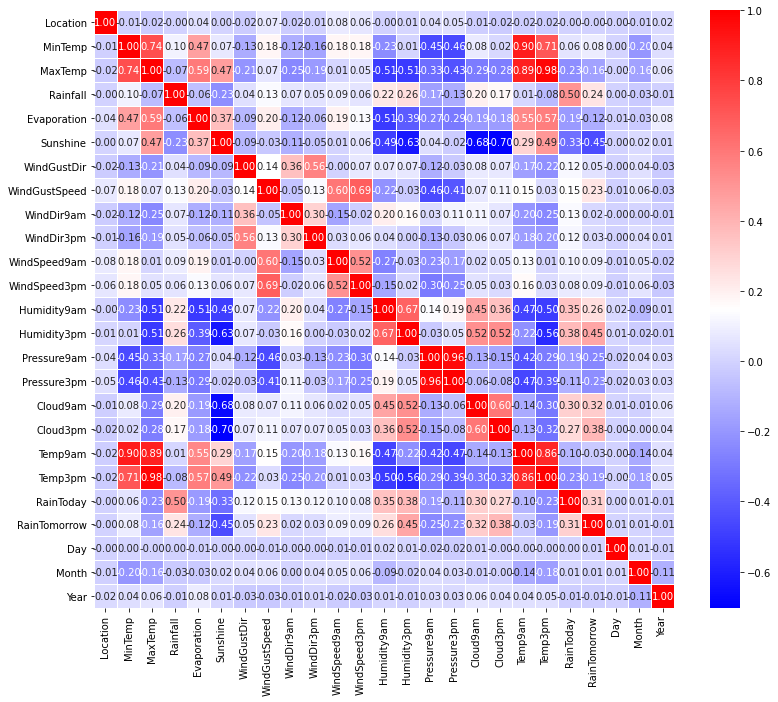

In [48]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(13,11))
ax = sns.heatmap(corr, annot=True, linewidths=.5, cmap='bwr', fmt='.2f')

In [49]:
df.drop(columns=['Date', 'MinTemp', 'WindGustDir', 'WindSpeed9am', 'WindSpeed3pm', 'Temp9am'], inplace=True)
df.head().T

,0,1,2,3,4
Location,2.0,2.0,2.0,2.0,2.0
MaxTemp,22.9,25.1,25.7,28.0,32.3
Rainfall,0.6,0.0,0.0,0.0,1.0
Evaporation,NaN,NaN,NaN,NaN,NaN
Sunshine,NaN,NaN,NaN,NaN,NaN
WindGustSpeed,44.0,44.0,46.0,24.0,41.0
WindDir9am,13.0,6.0,13.0,9.0,1.0
WindDir3pm,14.0,15.0,15.0,0.0,7.0
Humidity9am,71.0,44.0,38.0,45.0,82.0
Humidity3pm,22.0,25.0,30.0,16.0,33.0


In [50]:
# from scipy.stats import norm

# plt.subplots(figsize=(20,30))
# col = df.columns[2:16]
# lenght = len(col)

# for i, j in zip(col, range(lenght)):
#     plt.subplot((lenght/2), 3, j+1)
#     plt.subplots_adjust(wspace=.2, hspace=.5)
#     sns.distplot(df[i], kde=False, fit=norm)
#     plt.title(i)
    
# plt.savefig('displot.jpg')

In [51]:
df = fill_mean(df)

In [52]:
print('Missing Values percentage in each column:')
(df.isnull().sum(axis=0)/len(df))*100

Missing Values percentage in each column:


Location          0.000000
MaxTemp           0.000000
Rainfall          0.000000
Evaporation      42.789026
Sunshine         47.692924
WindGustSpeed     6.519308
WindDir9am        0.000000
WindDir3pm        0.000000
Humidity9am       0.000000
Humidity3pm       2.538803
Pressure9am       9.855619
Pressure3pm       9.832411
Cloud9am         37.735332
Cloud3pm         40.152469
Temp3pm           0.000000
RainToday         0.000000
RainTomorrow      0.000000
Day               0.000000
Month             0.000000
Year              0.000000
dtype: float64

In [53]:
df = fill_forward(df)

In [54]:
print('Missing Values percentage in each column:')
(df.isnull().sum(axis=0)/len(df))*100

Missing Values percentage in each column:


Location          0.000000
MaxTemp           0.000000
Rainfall          0.000000
Evaporation      42.789026
Sunshine         47.692924
WindGustSpeed     0.000000
WindDir9am        0.000000
WindDir3pm        0.000000
Humidity9am       0.000000
Humidity3pm       0.000000
Pressure9am       0.000000
Pressure3pm       0.000000
Cloud9am         37.735332
Cloud3pm         40.152469
Temp3pm           0.000000
RainToday         0.000000
RainTomorrow      0.000000
Day               0.000000
Month             0.000000
Year              0.000000
dtype: float64

In [55]:
df = fill_iterative(df)

In [56]:
(df.isna().sum(axis=0)/len(df))*100

Location         0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindDir9am       0.0
WindDir3pm       0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp3pm          0.0
RainToday        0.0
RainTomorrow     0.0
Day              0.0
Month            0.0
Year             0.0
dtype: float64

In [57]:
# split data and save to .csv
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2)

df_train.to_csv('train.csv', index=False)
df_test.to_csv('test.csv', index=False)


In [58]:
df_train = pd.read_csv('train.csv')
train_label = np.array(df_train['RainTomorrow'])
train_data = np.array(df_train.drop('RainTomorrow', axis=1))
print(collections.Counter(train_label))
df_train.head().T

Counter({0: 88264, 1: 25490})


,0,1,2,3,4
Location,40.000000,20.0,41.000000,13.0,9.000000
MaxTemp,12.100000,15.2,30.900000,33.1,25.800000
Rainfall,2.000000,0.0,0.000000,0.2,0.000000
Evaporation,-1.199065,2.2,8.722434,6.8,5.414123
Sunshine,1.873513,8.6,11.002367,6.6,10.884903
WindGustSpeed,19.000000,33.0,31.000000,30.0,39.000000
WindDir9am,16.000000,1.0,9.000000,0.0,2.000000
WindDir3pm,13.000000,4.0,5.000000,4.0,5.000000
Humidity9am,99.000000,77.0,39.000000,82.0,69.000000
Humidity3pm,97.000000,37.0,21.000000,62.0,34.000000


In [59]:
df_test = pd.read_csv('test.csv')
test_label = np.array(df_test['RainTomorrow'])
test_data = np.array(df_test.drop('RainTomorrow', axis=1))
df_test.head().T

,0,1,2,3,4
Location,2.000000,34.000000,15.0,40.000000,36.000000
MaxTemp,20.300000,21.500000,24.7,20.300000,23.900000
Rainfall,0.000000,0.000000,0.0,0.000000,0.000000
Evaporation,1.862823,30.200000,5.2,5.357590,6.164640
Sunshine,1.952129,9.297868,2.7,9.922622,8.816569
WindGustSpeed,33.000000,44.000000,44.0,30.000000,46.000000
WindDir9am,2.000000,13.000000,6.0,16.000000,12.000000
WindDir3pm,5.000000,13.000000,6.0,7.000000,11.000000
Humidity9am,94.000000,39.000000,78.0,46.000000,57.000000
Humidity3pm,63.000000,31.000000,51.0,20.000000,47.000000


In [60]:
print(f'train_data.shape: {train_data.shape}')
print(f'test_data.shape: {test_data.shape}')

train_data.shape: (113754, 19)
test_data.shape: (28439, 19)


### Build model

In [61]:
model = keras.Sequential([
    layers.Dense(512, 'relu', input_shape=(19, )),
    layers.Dense(256, 'relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    layers.Dense(128, 'relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    layers.Dense(64, 'relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    layers.Dense(2, 'softmax')
])

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
             )

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               10240     
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 130       
Total params: 182,850
Trainable params: 182,850
Non-trainable params: 0
_________________________________________________________________


### Training

In [62]:
history = model.fit(
    train_data,
    train_label,
    batch_size=512,
    epochs=100,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
178/178 [==============================] - 1s 5ms/step - loss: 43.2620 - accuracy: 0.6947 - val_loss: 25.6738 - val_accuracy: 0.4496
Epoch 2/100
178/178 [==============================] - 1s 5ms/step - loss: 23.4168 - accuracy: 0.7632 - val_loss: 21.2193 - val_accuracy: 0.8239
Epoch 3/100
178/178 [==============================] - 1s 5ms/step - loss: 19.8408 - accuracy: 0.8057 - val_loss: 18.4703 - val_accuracy: 0.7642
Epoch 4/100
178/178 [==============================] - 1s 5ms/step - loss: 17.2270 - accuracy: 0.8059 - val_loss: 15.9376 - val_accuracy: 0.8430
Epoch 5/100
178/178 [==============================] - 1s 5ms/step - loss: 14.8899 - accuracy: 0.8348 - val_loss: 13.8454 - val_accuracy: 0.8443
Epoch 6/100
178/178 [==============================] - 1s 5ms/step - loss: 13.0294 - accuracy: 0.8021 - val_loss: 12.0374 - val_accuracy: 0.8437
Epoch 7/100
178/178 [==============================] - 1s 5ms/step - loss: 11.2614 - accuracy: 0.8293 - val_loss: 10.4635 - val_ac

Epoch 58/100
178/178 [==============================] - 3s 15ms/step - loss: 0.5800 - accuracy: 0.8428 - val_loss: 0.5750 - val_accuracy: 0.8462
Epoch 59/100
178/178 [==============================] - 3s 15ms/step - loss: 0.5809 - accuracy: 0.8424 - val_loss: 0.5754 - val_accuracy: 0.8456
Epoch 60/100
178/178 [==============================] - 3s 14ms/step - loss: 0.5789 - accuracy: 0.8428 - val_loss: 0.5746 - val_accuracy: 0.8445
Epoch 61/100
178/178 [==============================] - 3s 14ms/step - loss: 0.5783 - accuracy: 0.8428 - val_loss: 0.5744 - val_accuracy: 0.8457
Epoch 62/100
178/178 [==============================] - 2s 13ms/step - loss: 0.5770 - accuracy: 0.8428 - val_loss: 0.5874 - val_accuracy: 0.8392
Epoch 63/100
178/178 [==============================] - 2s 12ms/step - loss: 0.5774 - accuracy: 0.8429 - val_loss: 0.5764 - val_accuracy: 0.8443
Epoch 64/100
178/178 [==============================] - 2s 13ms/step - loss: 0.5754 - accuracy: 0.8436 - val_loss: 0.5776 - val_ac

In [63]:
result = model.evaluate(test_data, test_label)
result

889/889 [==============================] - 1s 913us/step - loss: 0.5614 - accuracy: 0.8489


[0.5613793134689331, 0.8489046692848206]

### Save model

In [64]:
json_config = model.to_json()

with open('kaggle_rain_model_config_v03.json', 'w') as json_file:
    json_file.write(json_config)
    
model.save_weights('kaggle_rain_classifier_v03.h5')


### Load model & test

In [33]:
# with open('kaggle_rain_model_config_v01.json') as json_file:
#     json_config = json_file.read()
    
# new_model = keras.models.model_from_json(json_config)
# new_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
#                   loss=keras.losses.SparseCategoricalCrossentropy(),
#                   metrics=['accuracy']
# )
# new_model.load_weights('kaggle_rain_classifier_v01.h5')
# new_model.summary()

# result = model.evaluate(test_data, test_label)
# print(result)